In [1]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q

!pip install opendatasets -q

In [2]:
# import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import opendatasets as od

### Load Dataset

In [3]:
# download dataset
od.download("https://www.kaggle.com/datasets/vuppalaadithyasairam/bone-fracture-detection-using-xrays")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anjaleekalhari
Your Kaggle Key: ··········


100%|██████████| 172M/172M [00:01<00:00, 97.4MB/s]


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (224,224)

In [5]:
train_data_dir = "/content/bone-fracture-detection-using-xrays/archive (6)/train"
test_data_dir = "/content/bone-fracture-detection-using-xrays/archive (6)/val"

train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.1,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 8863 files belonging to 2 classes.
Using 7977 files for training.
Found 8863 files belonging to 2 classes.
Using 886 files for validation.
Found 600 files belonging to 2 classes.


In [6]:
class_names = train_data.class_names
class_names

['fractured', 'not fractured']

In [7]:
for image_batch,label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 224, 224, 3)
(32,)


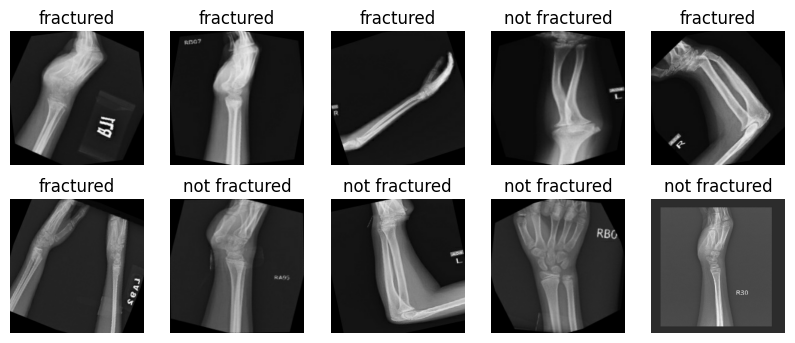

In [8]:
# plot data sample
plt.figure(figsize=(10,4))
for image,label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

### Scaling Images

In [9]:
for image,label in train_data.take(1):
    for i in range(1):
      print(image)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

In [10]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

### Data Augmentation

In [11]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(224,224,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  ]
)

### Model Building

In [12]:
model = tf.keras.models.Sequential()

model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)      

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

### Model Training

In [15]:
start_time = time.time()

history = model.fit(train_data,
                    epochs=20,
                    validation_data=validation_data)

end_time = time.time()

Epoch 1/20
250/250 [==============================] - 41s 100ms/step - loss: 0.6512 - accuracy: 0.6111 - val_loss: 0.6907 - val_accuracy: 0.4650
Epoch 2/20
250/250 [==============================] - 23s 91ms/step - loss: 0.6017 - accuracy: 0.6525 - val_loss: 0.8263 - val_accuracy: 0.4865
Epoch 3/20
250/250 [==============================] - 23s 93ms/step - loss: 0.5325 - accuracy: 0.7256 - val_loss: 0.6374 - val_accuracy: 0.6964
Epoch 4/20
250/250 [==============================] - 24s 94ms/step - loss: 0.4659 - accuracy: 0.7696 - val_loss: 0.9017 - val_accuracy: 0.5824
Epoch 5/20
250/250 [==============================] - 22s 87ms/step - loss: 0.4232 - accuracy: 0.7954 - val_loss: 0.3389 - val_accuracy: 0.8442
Epoch 6/20
250/250 [==============================] - 22s 89ms/step - loss: 0.3609 - accuracy: 0.8328 - val_loss: 0.4053 - val_accuracy: 0.8262
Epoch 7/20
250/250 [==============================] - 23s 90ms/step - loss: 0.3184 - accuracy: 0.8587 - val_loss: 0.3034 - val_accuracy

In [16]:
print(f'Total time for training {(end_time-start_time):.3f} seconds')

Total time for training 654.150 seconds


### Performance Analysis

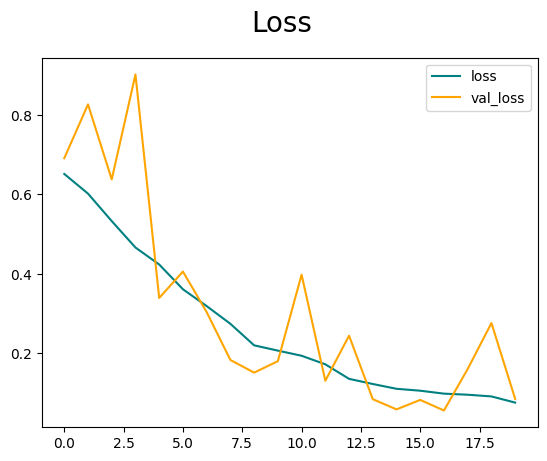

In [17]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

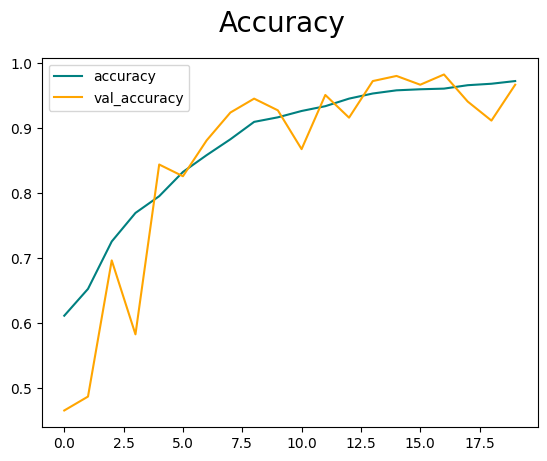

In [18]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

### Model Evaluation

In [19]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [20]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 414ms/step


In [21]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.6332454>

In [22]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [23]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.7683333>

### Test

In [24]:
!pip install opencv-python -q

In [25]:
import cv2

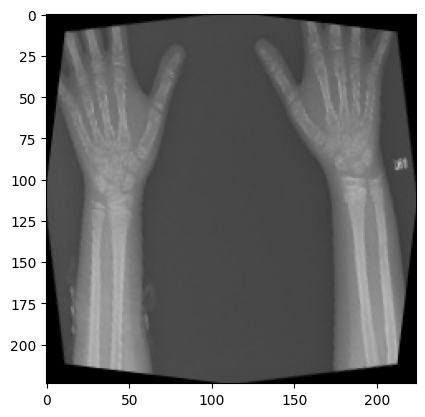

In [26]:
img = cv2.imread('/content/bone-fracture-detection-using-xrays/archive (6)/train/fractured/10-rotated1-rotated1.jpg')
plt.imshow(img)
plt.show()

In [27]:
resized_image = tf.image.resize(img, IMAGE_SIZE)
scaled_image = resized_image/255

In [28]:
scaled_image.shape

TensorShape([224, 224, 3])

In [29]:
np.expand_dims(scaled_image, 0).shape

(1, 224, 224, 3)

In [30]:
yhat = model.predict(np.expand_dims(scaled_image, 0))

1/1 [==============================] - 0s 133ms/step


In [31]:
yhat

array([[4.952256e-09]], dtype=float32)

In [32]:
class_names

['fractured', 'not fractured']

In [33]:
if yhat > 0.5:
    print(f'{class_names[1]}')
else:
    print(f'{class_names[0]}')

fractured
